In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def solveNormalLeastSquares(Au, bu, xu_0, method='CG', i_max=1e6, epsilon=1e-6):
    
    iCheckFPErr = np.max([50, int(np.floor(np.sqrt(np.size(Au, 1))))])
    
    switcher = {
        'SD': lambda : steepestDescentNormal(Au, bu, xu_0,
                                                        i_max=i_max, epsilon=epsilon,
                                                        iCheckFPErr=iCheckFPErr),
        'CG': lambda : conjugateGradientNormal(Au, bu, xu_0,
                                                        i_max=i_max, epsilon=epsilon,
                                                        iCheckFPErr=iCheckFPErr),
        'PCG': lambda : conjugateGradientPreconditionedNormal(Au, bu, xu_0,
                                                        i_max=i_max, epsilon=epsilon,
                                                        iCheckFPErr=iCheckFPErr),
    }
    x, X, n_steps = switcher.get(method)()

    print('Minimum norm solution =\n', x)
    print('No. of iterations =', n_steps)
    return x

def conjugateGradientNormal(Au, bu, xu, i_max=1e6, epsilon=1e-6, iCheckFPErr=50):
    i = 0
    x = Au.T @ xu; b = Au.T @ bu
    r = b - Au.T @ (Au @ x)
    d = r
    delta_new = r.T.dot(r)
    delta_0 = delta_new
    X = []; X.append(x)
    while (i < i_max) & (delta_new > epsilon ** 2 * delta_0):
        p = Au @ d
        q = Au.T @ p
        alpha = delta_new / (p.T.dot(p))
        x = x + alpha * d
        if i % iCheckFPErr == 0:
            r = b - Au.T @ (Au @ x)
        else:
            r = r - alpha * q
        delta_old = delta_new
        delta_new = r.T.dot(r)
        beta = delta_new / delta_old
        d = r + beta * d
        X.append(x)
        i += 1
    return x, np.array(X), i

def steepestDescentNormal(Au, bu, xu, i_max=1e6, epsilon=1e-6, iCheckFPErr=50):
    i = 0
    x = Au.T @ xu; b = Au.T @ bu
    r = b - Au.T @ (Au @ x)
    delta = r.T.dot(r)
    delta_0 = delta
    X = []; X.append(x)
    while (i < i_max) & (delta > epsilon ** 2 * delta_0):
        p = Au @ r
        q = Au.T @ p
        alpha = delta / (p.T.dot(p))
        x = x + alpha * r
        if i % iCheckFPErr == 0: # for large n: sqrt(n) might be appropriate here instead of 50
            r = b - Au.T @ (Au @ x)
        else:
            r = r - alpha * q
        delta = r.T.dot(r)
        X.append(x);
        i += 1
    return x, np.array(X), i

def conjugateGradientPreconditionedNormal(Au, bu, xu,
                                                   i_max=1e6, epsilon=1e-6, iCheckFPErr=50):
    i = 0
    x = Au.T @ xu; b = Au.T @ bu; A = Au.T @ Au
    r = b - A @ x
    d = precondition(A, r) # M_inverse * r
    delta_new = r.T.dot(d)
    delta_0 = delta_new
    X = []; X.append(x)
    while (i < i_max) & (delta_new > epsilon ** 2 * delta_0):
        q = A @ d
        alpha = delta_new / d.T.dot(q)
        x = x + alpha * d
        if i % iCheckFPErr == 0:
            r = b - A @ x
        else:
            r = r - alpha * q
        s = precondition(A, r)
        delta_old = delta_new
        delta_new = r.T.dot(s)
        beta = delta_new / delta_old
        d = s + beta * d
        X.append(x)
        i += 1
    return x, np.array(X), i

def precondition(A, r):
    M_inv_r = []
    for i, a_ii in enumerate(A.diagonal()):
        M_inv_r.append(1 / a_ii * r[i])
    return np.array(M_inv_r)

In [3]:
# Load dataset
A = np.loadtxt(os.path.join('/home/rob/data/databookuw', 'hald_ingredients.csv'), delimiter=',')
b = np.loadtxt(os.path.join('/home/rob/data/databookuw', 'hald_heat.csv'), delimiter=',')

In [4]:
# Solve by minimizing Least Squares Error
b_vec = b.reshape((-1, 1))
x_0 = np.zeros(np.shape(b_vec))
x_min = solveNormalLeastSquares(A, b_vec, x_0, method='CG')

Minimum norm solution =
 [[2.19304602]
 [1.15332597]
 [0.75850914]
 [0.48631933]]
No. of iterations = 4


In [5]:
# Solve Ax=b using SVD
U, S, VT = np.linalg.svd(A, full_matrices=0)
x_svd = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b
print('SVD solution =\n', x_svd)

SVD solution =
 [2.19304602 1.15332597 0.75850914 0.48631933]


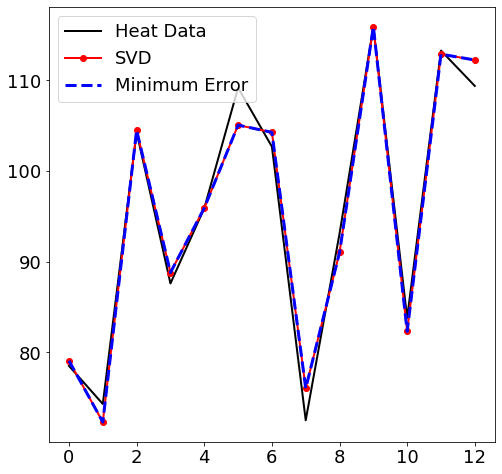

In [6]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

plt.plot(b, color='k', linewidth=2, label='Heat Data') # True relationship
plt.plot(A@x_svd, '-o', color='r', linewidth=2, markersize=6, label='SVD')
plt.plot(A@x_min, '--', color='b', linewidth=3, markersize=6, label='Minimum Error')
plt.legend()
plt.show()